In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from algorithms import *
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
#extract development and evaulation
df = pd.read_csv("dsl_data/development.csv")
df_eval = pd.read_csv("dsl_data/evaluation.csv")

In [4]:
condition = (df['Current language used for work/school'] == np.unique(df_eval['Current language used for work/school'].values)[0]) & (df['First Language spoken'] == np.unique(df_eval['First Language spoken'].values)[0]) & (df['Self-reported fluency level '] == np.unique(df_eval['Self-reported fluency level '].values)[0])
df = df.loc[condition]

In [5]:
df['intent'] = df['action']+ df['object']
# encoding y
dict = {}
for i, el in enumerate(df['intent'].unique()):
    dict[el] = i

df['intent'] = df['intent'].apply(lambda x: dict[x])
y = df['intent']

In [6]:
X_eval = pd.read_csv('x_eval.csv')
X = pd.read_csv('x.csv')

In [ ]:
#dropping irrelevant columns
df.drop(columns=["Self-reported fluency level ","First Language spoken", "Current language used for work/school","action","object", "intent"], inplace=True)

In [ ]:
#dropping irrelevant columns
df_eval.drop(columns=["Self-reported fluency level ","First Language spoken", "Current language used for work/school"], inplace=True)

In [ ]:
label_encoder(df, 'gender')
label_encoder(df_eval, 'gender')

In [ ]:
label_encoder(df, 'ageRange')
label_encoder(df_eval, 'ageRange')

In [ ]:
audio_feature_extraction(df)
audio_feature_extraction(df_eval)

In [ ]:
import librosa
import numpy as np

def extract_spectrogram(dataframe):
    audio_paths = dataframe["path"].values
    spectrograms = []
    for data in dataframe['data']:
        
        # Compute the spectrogram
        spectrogram = np.abs(librosa.stft(data))
        
        # Split the spectrogram into 20 chunks
        n_chunks = 20
        chunks = np.array_split(spectrogram, n_chunks)
        
        # Append the chunks to the list of spectrograms
        spectrograms.append(chunks)
    
    # Add the spectrogram chunks to the dataframe as new columns
    for i in range(n_chunks):
        dataframe["mean_spectrogram_" + str(i)] = [np.mean(chunk[i]) for chunk in spectrograms]
        dataframe["std_spectrogram_" + str(i)] = [np.std(chunk[i]) for chunk in spectrograms]
    return dataframe


In [ ]:
extract_spectrogram(df)

In [ ]:
extract_spectrogram(df_eval)

In [ ]:
def extract_mfcc(dataframe):
    mfcc_array = []
    for data, rate in zip(dataframe['data'], dataframe['rate']):
        # Load the audio file
        mfcc = librosa.feature.mfcc(y=data, sr=rate, n_mfcc=30)        
        # Split the spectrogram into 20 chunks
        n_chunks = 20
        chunks = np.array_split(mfcc, n_chunks)
        
        # Append the chunks to the list of spectrograms
        mfcc_array.append(chunks)
    
    # Add the spectrogram chunks to the dataframe as new columns
    for i in range(n_chunks):
        dataframe["mean_mfcc_" + str(i)] = [np.mean(chunk[i]) for chunk in mfcc_array]
        dataframe["std_mfcc_" + str(i)] = [np.std(chunk[i]) for chunk in mfcc_array]
    return dataframe



In [ ]:
extract_mfcc(df)

In [ ]:
extract_mfcc(df_eval)

In [ ]:
df_eval.drop(columns=['Id','ageRange','data','speakerId','path', 'rate'],inplace= True)
df.drop(columns=['Id','ageRange','data','speakerId','path', 'rate'],inplace= True)


In [ ]:
X = df.copy()
X_eval = df_eval.copy()

In [ ]:
zcr_feature(df)
zcr_feature(df_eval)

In [ ]:
X['']

In [ ]:


X.to_csv('x.csv',index=False)


X_eval.to_csv('x_eval.csv', index=False)

In [31]:
X_eval = pd.read_csv('x_eval.csv')
X = pd.read_csv('x.csv')

In [17]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

scaler.fit(X)
scaler.fit(X_eval)

X = scaler.transform(X)
X_eval = scaler.transform(X_eval)



In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.01, 0.1, 1, 10]}

# Initialize the SVC
svc = SVC()

# Initialize the GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
import numpy as np

# Example dataset
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
y = np.array([0, 1, 2])

# Define the parameter grid
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.1, 1, 10]}

# Initialize the SVC
svc = SVC()

# Initialize the KFold
kf = KFold(n_splits=5)

# Initialize the GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=kf)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


In [43]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(classes=np.unique(y_train),class_weight='balanced',y=y_train)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
model = SVC(class_weight=class_weights)
model.fit(X_train, y_train)

SVC(class_weight={0: 2.7067099567099566, 1: 1.246345514950166,
                  2: 1.7571428571428571, 3: 0.5938266719430154,
                  4: 0.5337933978372226, 5: 1.1600185528756957,
                  6: 1.190952380952381})

In [44]:
y_pred = model.predict(X_test)

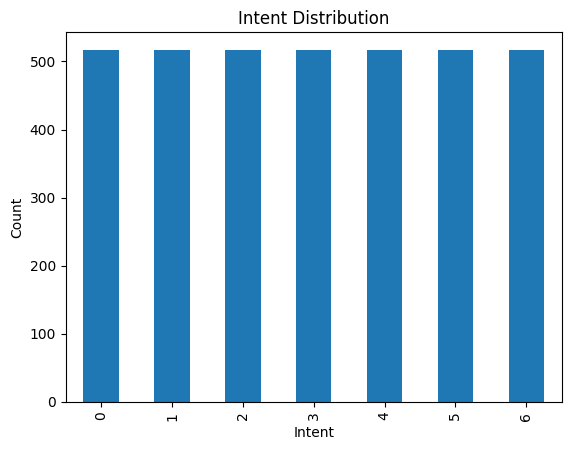

In [44]:
import matplotlib.pyplot as plt
y_resampled.value_counts().plot(kind='bar', xlabel='Intent', ylabel='Count')

# Add a title to the chart
plt.title("Intent Distribution")

# Display the chart
plt.show()

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [52]:
def new_svm_model(X_train, y_train, X_test):
    clf = SVC(kernel = 'rbf', C=100, gamma=0.01)
    # train the model on the training data
    clf.fit(X_train, y_train)
    # predict the target values for the test data
    # returning the y_predict
    return clf.predict(X_test)
y_pred = new_svm_model(X_resampled, y_resampled, X_eval)

In [45]:
accuracy_calculator(y_test, y_pred)

0.38699360341151384

In [41]:
key_mapping = np.vectorize(lambda x: next(key for key, value in dict.items() if value == x))
keys_arr = key_mapping(y_pred)
pd.Series(keys_arr).to_csv('predictions.csv')